In [1]:
#Import necessary modules.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set option to make pandas dataframe full width with scrollable window.
pd.set_option('display.max_columns', None)

Prep the Raw Data:

In [2]:
# Initialize directories.
players_directory = './players/'
shots_directory = './shots/'

# Load the data into dataframes.
players_df = pd.read_csv(players_directory + 'players.csv')
salaries_df = pd.read_csv(players_directory + 'salaries_1985to2018.csv')
# shots_2004_df = pd.read_csv(shots_directory + 'NBA_2004_Shots.csv')
# shots_2005_df = pd.read_csv(shots_directory + 'NBA_2005_Shots.csv')
# shots_2006_df = pd.read_csv(shots_directory + 'NBA_2006_Shots.csv')
# shots_2007_df = pd.read_csv(shots_directory + 'NBA_2007_Shots.csv')
# shots_2008_df = pd.read_csv(shots_directory + 'NBA_2008_Shots.csv')
# shots_2009_df = pd.read_csv(shots_directory + 'NBA_2009_Shots.csv')
# shots_2010_df = pd.read_csv(shots_directory + 'NBA_2010_Shots.csv')
# shots_2011_df = pd.read_csv(shots_directory + 'NBA_2011_Shots.csv')
# shots_2012_df = pd.read_csv(shots_directory + 'NBA_2012_Shots.csv')
# shots_2013_df = pd.read_csv(shots_directory + 'NBA_2013_Shots.csv')
shots_2014_df = pd.read_csv(shots_directory + 'NBA_2014_Shots.csv')
shots_2015_df = pd.read_csv(shots_directory + 'NBA_2015_Shots.csv')
shots_2016_df = pd.read_csv(shots_directory + 'NBA_2016_Shots.csv')
shots_2017_df = pd.read_csv(shots_directory + 'NBA_2017_Shots.csv')
shots_2018_df = pd.read_csv(shots_directory + 'NBA_2018_Shots.csv')

Prep the Players/Salary Data:

In [3]:
# Convert 'season' column in salaries_df to only the starting year. (ex. '2017-18' becomes '2017')
salaries_df['season'] = salaries_df['season'].str.split('-').str[0].astype(int)

# Merge players with salaries on '_id' and 'player_id' with an inner join, meaning we only keep the matching records.
players_salaries_df = pd.merge(players_df, salaries_df, left_on='_id', right_on='player_id', how='inner')

# Group the records by the name and season. This ensures there is only one record, per player, in each season. If there are dups, we just take the first occurrence of the values.
players_salaries_df = players_salaries_df.groupby(['name', 'season']).agg({'salary': 'first', 'draft_year': 'first','_id': 'first'}).reset_index()

# Clean player names in players_salaries_df so there is no leading or trailing white space.
players_salaries_df['name'] = players_salaries_df['name'].str.strip()

#Prep the Shots Data:

In [4]:
# Concatenate shots data for 2014-2018.
shots_df = pd.concat([shots_2014_df, shots_2015_df, shots_2016_df, shots_2017_df, shots_2018_df])

# Add a 'season' column based on SEASON_1 and convert it to integer. This will make it easier to merge later since it ensures it matches the players_salaries_df.
shots_df['season'] = shots_df['SEASON_1'].astype(int)

# Remove duplicates in shots data based on several key columns. This ensures every single shot accounted for is truly unique.
shots_df = shots_df.drop_duplicates(subset=['PLAYER_NAME', 'season', 'GAME_ID', 'LOC_X', 'LOC_Y', 'EVENT_TYPE'])

# Clean player names in shots_df so there is no leading or trailing white space.
shots_df['PLAYER_NAME'] = shots_df['PLAYER_NAME'].str.strip()

Prep the Finalized Data:

In [5]:
# Merge shots data with the players/salaries data on player name and season. Ensure that we only get one salary record per player-season. Use inner join to only keep matching records.
final_merged_df = pd.merge(shots_df, players_salaries_df, left_on=['PLAYER_NAME', 'season'], right_on=['name', 'season'], how='inner')

# Calculate 'years_in_nba' based on draft year and the latest season year (e.g., 2018)
latest_season_year = 2018
final_merged_df['draft_year'] = pd.to_numeric(final_merged_df['draft_year'], errors='coerce')  # Ensure numeric type
final_merged_df['years_in_nba'] = final_merged_df['draft_year'].apply(
    lambda x: latest_season_year - x if pd.notnull(x) else 0 # If no draft year, default to 0 years in NBA.
)

# Clean invalid or missing data for numeric columns. If missing years in NBA, fill it with a 0.
final_merged_df['years_in_nba'] = final_merged_df['years_in_nba'].fillna(0)
# Ensure salary is a numeric.
final_merged_df['salary'] = pd.to_numeric(final_merged_df['salary'], errors='coerce')

# Verify the results by checking how many rows remain.
print(f"Original shots_df rows: {len(shots_df)}")
print(f"Merged final_merged_df rows: {len(final_merged_df)}")

Original shots_df rows: 1028342
Merged final_merged_df rows: 765913


In [6]:
# Check out the finalized data.
final_merged_df

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,HOME_TEAM,AWAY_TEAM,EVENT_TYPE,SHOT_MADE,ACTION_TYPE,SHOT_TYPE,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,season,name,salary,draft_year,_id,years_in_nba
0,2014,2013-14,1610612762,Utah Jazz,202330,Gordon Hayward,F,SF,04-16-2014,21301218,MIN,UTA,Made Shot,True,Layup Shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,-0.9,4.65,1,6,0,1,2014,Gordon Hayward,14746000,2010.0,haywago01,8.0
1,2014,2013-14,1610612762,Utah Jazz,202330,Gordon Hayward,F,SF,04-16-2014,21301218,MIN,UTA,Made Shot,True,Fadeaway Jump Shot,2PT Field Goal,Mid-Range,Right Side,R,8-16 ft.,-13.3,12.95,15,6,3,40,2014,Gordon Hayward,14746000,2010.0,haywago01,8.0
2,2014,2013-14,1610612762,Utah Jazz,202330,Gordon Hayward,F,SF,04-16-2014,21301218,MIN,UTA,Missed Shot,False,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center,LC,24+ ft.,19.1,24.95,27,5,0,0,2014,Gordon Hayward,14746000,2010.0,haywago01,8.0
3,2014,2013-14,1610612762,Utah Jazz,202330,Gordon Hayward,F,SF,04-16-2014,21301218,MIN,UTA,Missed Shot,False,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center,LC,16-24 ft.,13.0,18.15,18,5,0,3,2014,Gordon Hayward,14746000,2010.0,haywago01,8.0
4,2014,2013-14,1610612762,Utah Jazz,202330,Gordon Hayward,F,SF,04-16-2014,21301218,MIN,UTA,Missed Shot,False,Layup Shot,2PT Field Goal,Restricted Area,Center,C,Less Than 8 ft.,0.5,5.95,0,5,0,48,2014,Gordon Hayward,14746000,2010.0,haywago01,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765908,2017,2016-17,1610612758,Sacramento Kings,200770,Jordan Farmar,G,PG,11-05-2016,21600085,MIL,SAC,Missed Shot,False,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center,LC,24+ ft.,14.5,43.85,41,3,0,0,2017,Jordan Farmar,510921,2006.0,farmajo01,12.0
765909,2017,2016-17,1610612758,Sacramento Kings,200770,Jordan Farmar,G,PG,11-05-2016,21600085,MIL,SAC,Missed Shot,False,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center,C,Less Than 8 ft.,6.6,6.85,6,3,3,36,2017,Jordan Farmar,510921,2006.0,farmajo01,12.0
765910,2017,2016-17,1610612758,Sacramento Kings,200770,Jordan Farmar,G,PG,11-05-2016,21600085,MIL,SAC,Missed Shot,False,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center,RC,24+ ft.,-16.8,25.25,26,2,2,35,2017,Jordan Farmar,510921,2006.0,farmajo01,12.0
765911,2017,2016-17,1610612758,Sacramento Kings,200770,Jordan Farmar,G,PG,11-05-2016,21600085,MIL,SAC,Made Shot,True,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center,RC,24+ ft.,-21.2,20.65,26,2,5,10,2017,Jordan Farmar,510921,2006.0,farmajo01,12.0


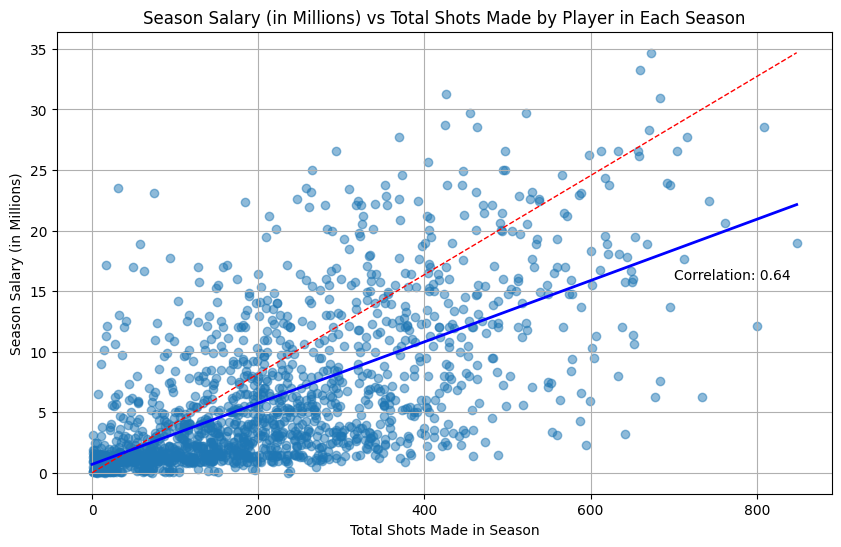

In [7]:
# Filter only shots that were made.
shots_made = final_merged_df[final_merged_df['SHOT_MADE'] == True]

# Group data by player and season and count total shots made in that specific season.
seasonal_stats = shots_made.groupby(['PLAYER_NAME', 'season']).agg(season_salary=('salary', 'first'), total_shots_made=('GAME_ID', 'count')).reset_index()

# Convert salary to millions.
seasonal_stats['season_salary'] = seasonal_stats['season_salary'] / 1_000_000

# Plot the relationship between season salary and total shots made.
plt.figure(figsize=(10, 6))
plt.scatter(seasonal_stats['total_shots_made'], seasonal_stats['season_salary'], alpha=0.5)

# Add a reference line to show a theoretical perfect correlation.
max_shots = seasonal_stats['total_shots_made'].max()
max_salary = seasonal_stats['season_salary'].max()
plt.plot([0, max_shots], [0, max_salary], color='red', linestyle='--', linewidth=1)

# Calculate and plot regression line
coeffs = np.polyfit(seasonal_stats['total_shots_made'], seasonal_stats['season_salary'], 1)
x_vals = np.linspace(0, max_shots, 100)
y_vals = np.polyval(coeffs, x_vals)
plt.plot(x_vals, y_vals, color='blue', linestyle='-', linewidth=2, label='Regression Line')

# Add correlation coefficient
correlation = seasonal_stats['total_shots_made'].corr(seasonal_stats['season_salary'])
plt.annotate(f"Correlation: {correlation:.2f}", xy=(700, 16))

# Add plot details.
plt.title("Season Salary (in Millions) vs Total Shots Made by Player in Each Season")
plt.xlabel("Total Shots Made in Season")
plt.ylabel("Season Salary (in Millions)")
plt.grid(True)
plt.show()

In [8]:
# Top 10 players/shots made in a single season.
top_10_shots = seasonal_stats.sort_values(by='total_shots_made', ascending=False).head(10)
print(top_10_shots[['PLAYER_NAME', 'season', 'total_shots_made', 'season_salary']])


             PLAYER_NAME  season  total_shots_made  season_salary
855         Kevin Durant    2014               848      18.995624
1312   Russell Westbrook    2017               809      28.530608
1379       Stephen Curry    2016               800      12.112359
945         LeBron James    2014               762      20.644400
212      Carmelo Anthony    2014               743      22.458000
823   Karl-Anthony Towns    2017               734       6.216840
349        DeMar DeRozan    2017               716      27.739975
143        Blake Griffin    2014               712      17.674612
626         James Harden    2016               704      26.540100
14          Al Jefferson    2014               696      13.666667


In [9]:
# Top 10 players/salaries in a single season.
top_10_salaries = seasonal_stats.sort_values(by='season_salary', ascending=False).head(10)
print(top_10_salaries[['PLAYER_NAME', 'season', 'total_shots_made', 'season_salary']])

            PLAYER_NAME  season  total_shots_made  season_salary
1380      Stephen Curry    2017               673      34.682550
948        LeBron James    2017               660      33.285709
1205       Paul Millsap    2017               426      31.269231
947        LeBron James    2016               683      30.963450
533      Gordon Hayward    2017               522      29.727900
146       Blake Griffin    2017               455      29.727900
907          Kyle Lowry    2017               425      28.703704
1312  Russell Westbrook    2017               809      28.530608
1067        Mike Conley    2017               463      28.530608
627        James Harden    2017               670      28.299399
